In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pysparkling import *
import h2o

ss = SparkSession.builder.getOrCreate()
conf = H2OConf().setLogLevel("ERRR") # TRACE,DEBUG,INFO,WARN,ERRR,FATAL
hc = H2OContext.getOrCreate(conf)


22/03/06 20:13:55 WARN Utils: Your hostname, Fans-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.0.0.115 instead (on interface en0)
22/03/06 20:13:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/03/06 20:13:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/06 20:13:58 WARN InternalH2OBackend: Increasing 'spark.locality.wait' to value 0 (Infinitive) as we need to ensure we run on the nodes with H2O


Connecting to H2O server at http://10.0.0.115:54323 ... successful.


H2O_cluster_uptime:,21 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,18 days
H2O_cluster_name:,sparkling-water-fanli_local-1646626437811
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,493.2 Mb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.36.0.3-1-3.2
 * H2O name: sparkling-water-fanli_local-1646626437811
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,10.0.0.115,54321)
  ------------------------

  Open H2O Flow in browser: http://10.0.0.115:54323 (CMD + click in Mac OSX)

    


## Create H2OFrames

In [2]:
def toDoubleSafe(v):
    try:
        return float(v)
    except:
        return str(v) #if it is not a float type return as a string.
    
adultschema = StructType([
    StructField("age",DoubleType(),True),
    StructField("workclass",StringType(),True),
    StructField("fnlwgt",DoubleType(),True),
    StructField("education",StringType(),True),
    StructField("marital_status",StringType(),True),
    StructField("occupation",StringType(),True),
    StructField("relationship",StringType(),True),
    StructField("race",StringType(),True),
    StructField("sex",StringType(),True),
    StructField("capital_gain",DoubleType(),True),
    StructField("capital_loss",DoubleType(),True),
    StructField("hours_per_week",DoubleType(),True),
    StructField("native_country",StringType(),True),
    StructField("income",StringType(),True)
])

#load and convert the data
census_raw = ss.sparkContext.textFile("../Data/adult.raw", 4).map(lambda x:  x.split(", "))
census_raw = census_raw.map(lambda row:  [toDoubleSafe(x) for x in row])

dfraw = ss.createDataFrame(census_raw, adultschema)

adult_h2o = hc.asH2OFrame(dfraw,'adult')

In [3]:
adult_h2o.show()

age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
37,Private,284582,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
49,Private,160187,9th,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
52,Self-emp-not-inc,209642,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
31,Private,45781,Masters,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
42,Private,159449,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


## Split Dataframe

In [4]:
splitted_adult = adult_h2o.split_frame([.8],seed=1)
adult_train_h2o = splitted_adult[0]
adult_valid_h2o =  splitted_adult[1]

## Apply AutoML

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html

http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/automl/autoh2o.html

http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.automl.autoh2o.H2OAutoML


### Identify predictors and response

In [21]:
from h2o.automl import H2OAutoML
model_automl = H2OAutoML(max_models=10,
                        max_runtime_secs=120,
                        seed = 1,
                        nfolds= 5)

In [22]:
predictors= adult_valid_h2o.columns
response = 'income'
predictors.remove(response)

model_automl.train(x= predictors,
                  y = response,
                  training_frame=adult_train_h2o)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_2_AutoML_4_20220306_203803

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.07101909569780657
RMSE: 0.2664940819189172
LogLoss: 0.22837810054771254
Null degrees of freedom: 10045
Residual degrees of freedom: 10038
Null deviance: 10877.629330223503
Residual deviance: 4588.57279620464
AIC: 4604.57279620464
AUC: 0.9540643687076237
AUCPR: 0.8806868659051662
Gini: 0.9081287374152474

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4025158165971625: 


,,<=50K,>50K,Error,Rate
0,<=50K,7174.0,545.0,0.0706,(545.0/7719.0)
1,>50K,491.0,1836.0,0.211,(491.0/2327.0)
2,Total,7665.0,2381.0,0.1031,(1036.0/10046.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.402516,0.779949,190.0
1,max f2,0.208709,0.843687,268.0
2,max f0point5,0.674153,0.818136,104.0
3,max accuracy,0.451341,0.900259,173.0
4,max precision,0.996955,1.000000,0.0
5,max recall,0.013869,1.000000,379.0
6,max specificity,0.996955,1.000000,0.0
7,max absolute_mcc,0.432585,0.713771,180.0
8,max min_per_class_accuracy,0.296524,0.874854,232.0
9,max mean_per_class_accuracy,0.237029,0.876876,256.0



Gains/Lift Table: Avg response rate: 23.16 %, avg score: 23.57 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010054,0.995181,4.317147,4.317147,1.000000,0.996210,1.000000,0.996210,0.043404,0.043404,331.714654,331.714654,0.043404
1,2,0.020008,0.993201,4.317147,4.317147,1.000000,0.994353,1.000000,0.995286,0.042974,0.086377,331.714654,331.714654,0.086377
2,3,0.030062,0.989753,4.317147,4.317147,1.000000,0.991572,1.000000,0.994044,0.043404,0.129781,331.714654,331.714654,0.129781
3,4,0.040016,0.983375,4.317147,4.317147,1.000000,0.986927,1.000000,0.992274,0.042974,0.172755,331.714654,331.714654,0.172755
4,5,0.050070,0.972472,4.317147,4.317147,1.000000,0.978219,1.000000,0.989451,0.043404,0.216158,331.714654,331.714654,0.216158
5,6,0.100040,0.790456,4.093549,4.205459,0.948207,0.877063,0.974129,0.933313,0.204555,0.420713,309.354931,320.545917,0.417345
6,7,0.150010,0.636609,3.302359,3.904626,0.764940,0.718035,0.904446,0.861601,0.165019,0.585733,230.235911,290.462557,0.567077
7,8,0.200080,0.482497,2.566256,3.569700,0.594433,0.559046,0.826866,0.785887,0.128492,0.714224,156.625609,256.970027,0.669141
8,9,0.300020,0.294383,1.625380,2.922024,0.376494,0.382350,0.676841,0.651464,0.162441,0.876665,62.537987,192.202354,0.750483
9,10,0.400060,0.146614,0.816177,2.395431,0.189055,0.216052,0.554864,0.542584,0.081650,0.958315,-18.382304,139.543090,0.726550




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.08746242134288451
RMSE: 0.29574046280968136
LogLoss: 0.27545547273749665
Null degrees of freedom: 39128
Residual degrees of freedom: 39121
Null deviance: 43032.6742109499
Residual deviance: 21556.59438549101
AIC: 21572.59438549101
AUC: 0.9292903889405826
AUCPR: 0.8303520848292216
Gini: 0.8585807778811652

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35888156760448753: 


,,<=50K,>50K,Error,Rate
0,<=50K,26535.0,3245.0,0.109,(3245.0/29780.0)
1,>50K,2095.0,7254.0,0.2241,(2095.0/9349.0)
2,Total,28630.0,10499.0,0.1365,(5340.0/39129.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.358882,0.730955,214.0
1,max f2,0.145305,0.810305,302.0
2,max f0point5,0.665867,0.767097,107.0
3,max accuracy,0.509979,0.874058,158.0
4,max precision,0.997054,1.000000,0.0
5,max recall,0.001109,1.000000,399.0
6,max specificity,0.997054,1.000000,0.0
7,max absolute_mcc,0.421654,0.642394,189.0
8,max min_per_class_accuracy,0.271362,0.842871,247.0
9,max mean_per_class_accuracy,0.204955,0.845142,274.0



Gains/Lift Table: Avg response rate: 23.89 %, avg score: 23.90 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010018,0.995292,4.185367,4.185367,1.000000,0.996434,1.000000,0.996434,0.041930,0.041930,318.536742,318.536742,0.041930
1,2,0.020011,0.992934,4.185367,4.185367,1.000000,0.994132,1.000000,0.995284,0.041823,0.083752,318.536742,318.536742,0.083752
2,3,0.030003,0.989572,4.163959,4.178237,0.994885,0.991296,0.998296,0.993956,0.041609,0.125361,316.395889,317.823732,0.125294
3,4,0.040021,0.983700,4.164014,4.174677,0.994898,0.986893,0.997446,0.992188,0.041716,0.167077,316.401350,317.467683,0.166942
4,5,0.050014,0.972986,4.142550,4.168258,0.989770,0.978760,0.995912,0.989505,0.041395,0.208471,314.255036,316.825810,0.208203
5,6,0.100003,0.785797,3.691083,3.929732,0.881902,0.875429,0.938922,0.932482,0.184512,0.392983,269.108323,292.973164,0.384958
6,7,0.150017,0.644059,2.850840,3.570040,0.681145,0.716103,0.852981,0.860343,0.142582,0.535565,185.084045,257.003998,0.506586
7,8,0.200005,0.495456,2.379411,3.272459,0.568507,0.570184,0.781881,0.787822,0.118943,0.654509,137.941133,227.245889,0.597188
8,9,0.300008,0.301965,1.646123,2.730347,0.393304,0.392017,0.652355,0.655887,0.164617,0.819125,64.612330,173.034702,0.682087
9,10,0.400010,0.156262,0.996873,2.296978,0.238180,0.225694,0.548812,0.548339,0.099690,0.918815,-0.312741,129.697841,0.681676


## Leader Board

Reported on cross-validation data.predictors

In [23]:
model_automl.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_2_AutoML_4_20220306_203803,0.92929,0.275455,0.830352,0.166527,0.29574,0.0874624
StackedEnsemble_BestOfFamily_3_AutoML_4_20220306_203803,0.929222,0.275511,0.830243,0.167317,0.295779,0.0874853
StackedEnsemble_BestOfFamily_5_AutoML_4_20220306_203803,0.928882,0.311732,0.828561,0.165118,0.305024,0.0930396
StackedEnsemble_AllModels_1_AutoML_4_20220306_203803,0.92886,0.276398,0.829555,0.165367,0.296123,0.0876888
StackedEnsemble_BestOfFamily_2_AutoML_4_20220306_203803,0.928541,0.276834,0.828919,0.164432,0.296407,0.0878573
StackedEnsemble_AllModels_3_AutoML_4_20220306_203803,0.928417,0.27771,0.828003,0.176543,0.296351,0.0878241
GBM_3_AutoML_4_20220306_203803,0.928315,0.277869,0.828017,0.168082,0.296806,0.0880937
StackedEnsemble_BestOfFamily_4_AutoML_4_20220306_203803,0.927978,0.285242,0.825874,0.165877,0.297455,0.0884792
GBM_2_AutoML_4_20220306_203803,0.927865,0.278652,0.827774,0.168311,0.296927,0.0881656
StackedEnsemble_AllModels_4_AutoML_4_20220306_203803,0.927854,0.300418,0.826702,0.168254,0.301085,0.0906521


## Prediction

In [24]:
predictions = model_automl.predict(adult_valid_h2o)


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [25]:
predictions

predict,<=50K,>50K
<=50K,0.981611,0.0183885
>50K,0.0164865,0.983513
>50K,0.144749,0.855251
<=50K,0.981241,0.0187592
>50K,0.373017,0.626983
<=50K,0.998714,0.0012859
>50K,0.417797,0.582203
>50K,0.143527,0.856473
<=50K,0.943827,0.0561729
>50K,0.538552,0.461448


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_2_AutoML_4_20220306_203803


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3811361283040613: 


,,<=50K,>50K,Error,Rate
0,<=50K,6641.0,734.0,0.0995,(734.0/7375.0)
1,>50K,550.0,1788.0,0.2352,(550.0/2338.0)
2,Total,7191.0,2522.0,0.1322,(1284.0/9713.0)


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

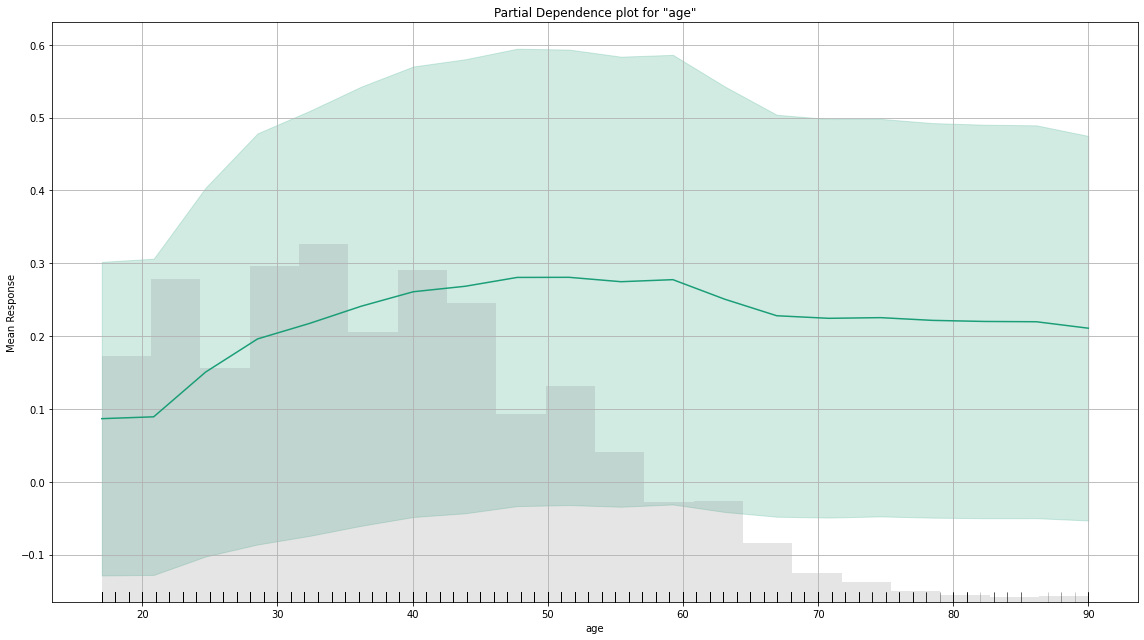

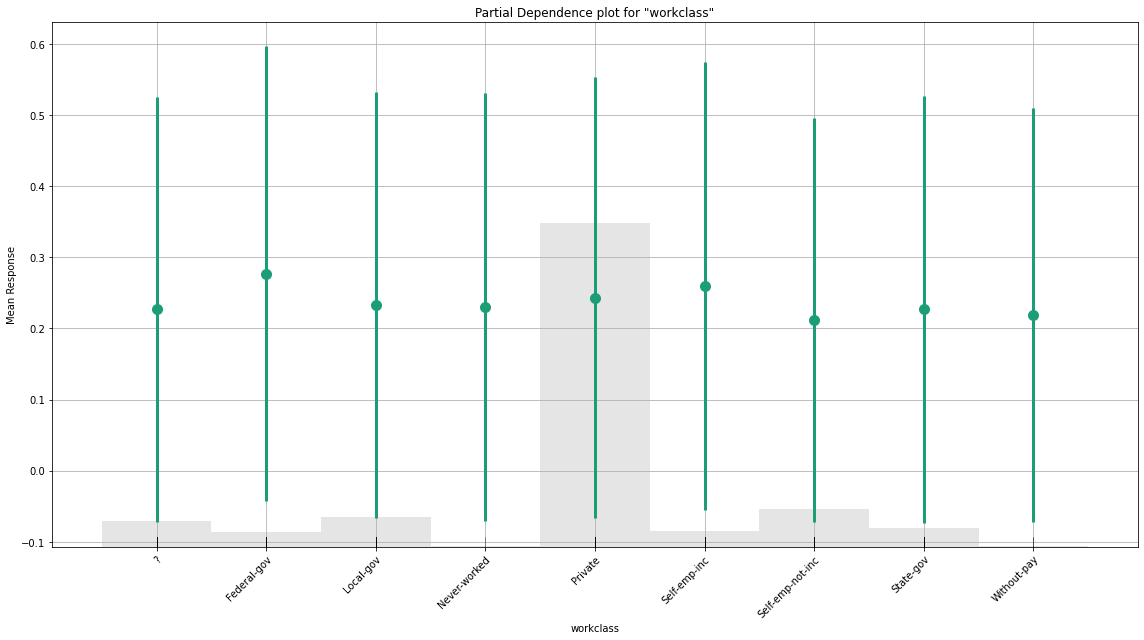

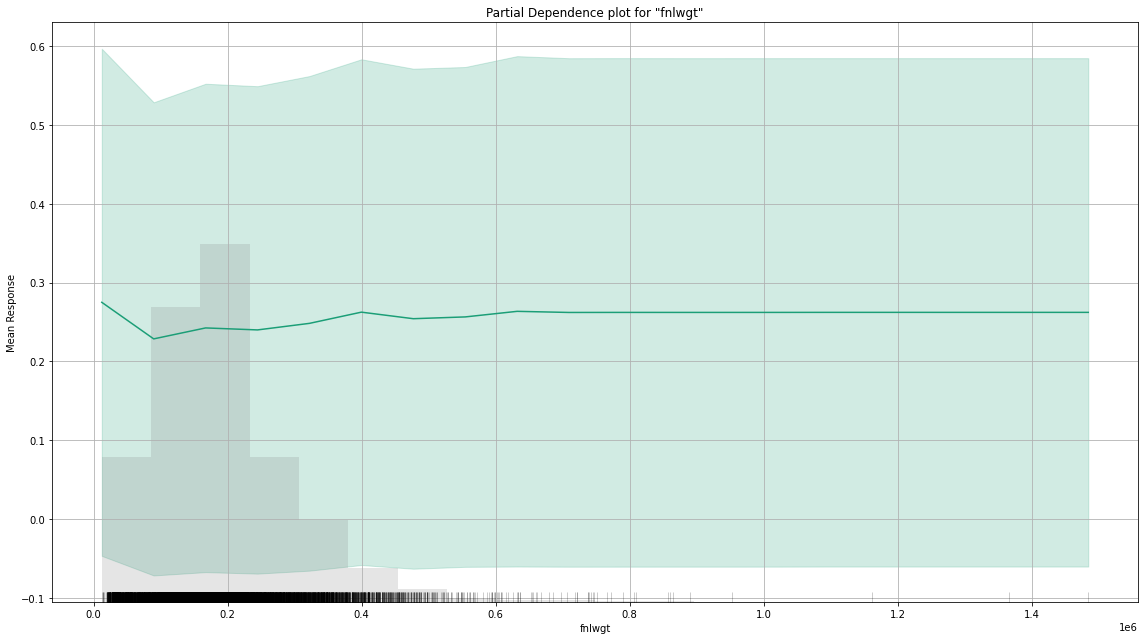

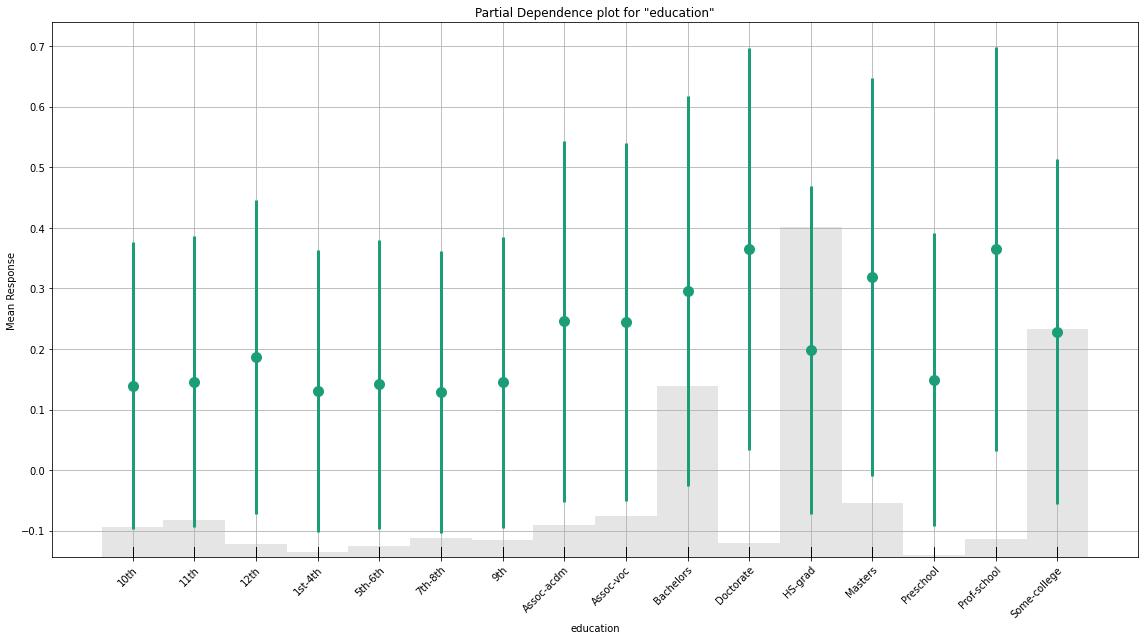

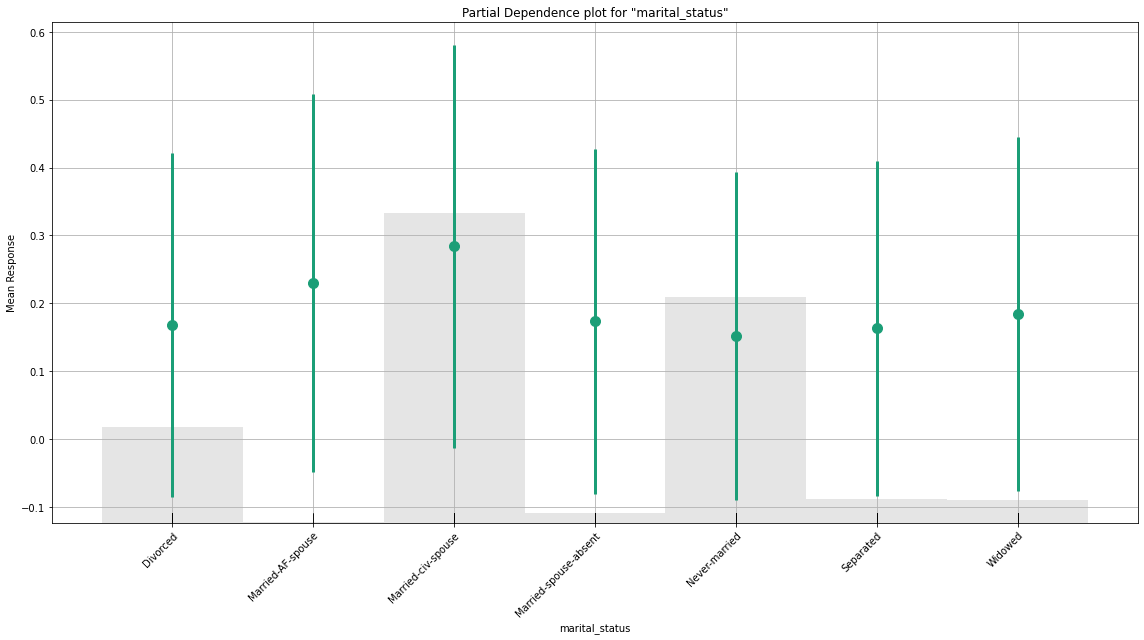

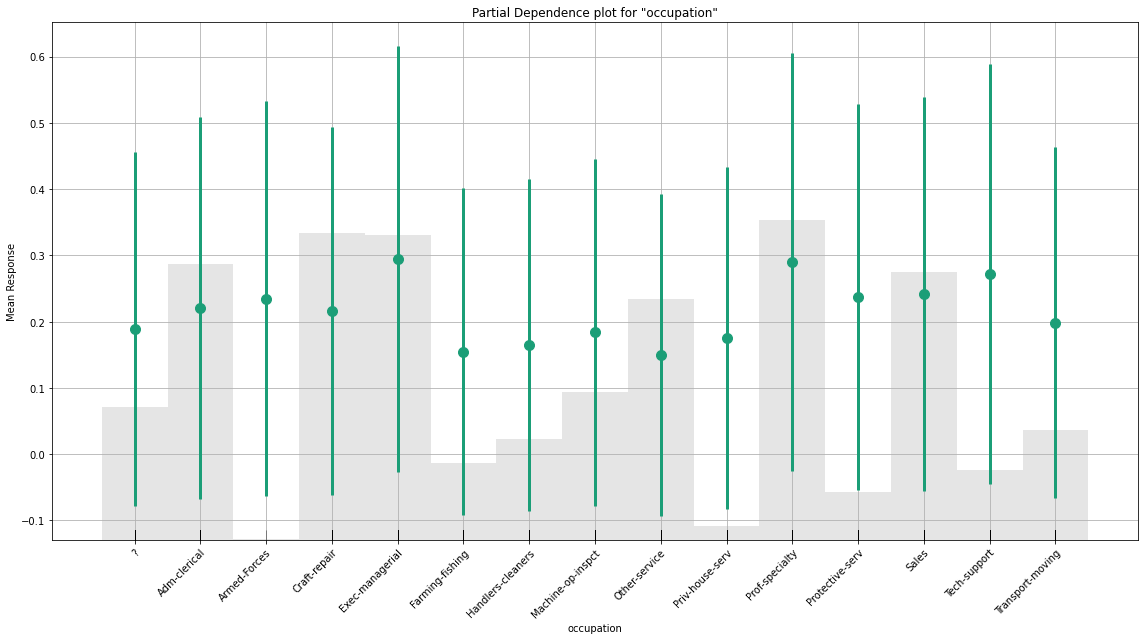

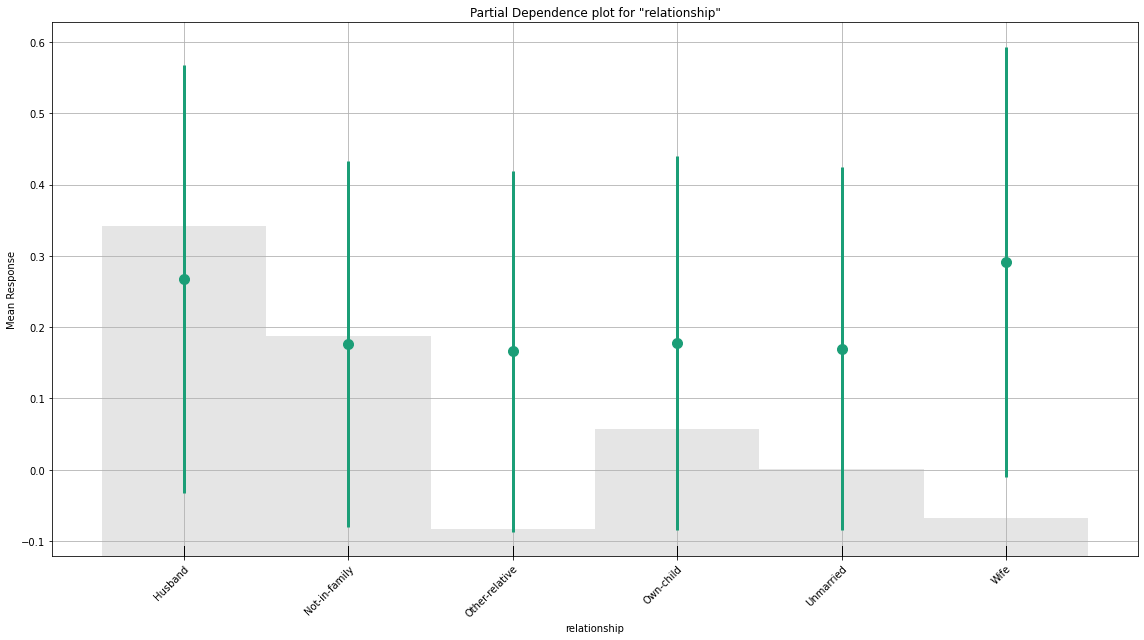

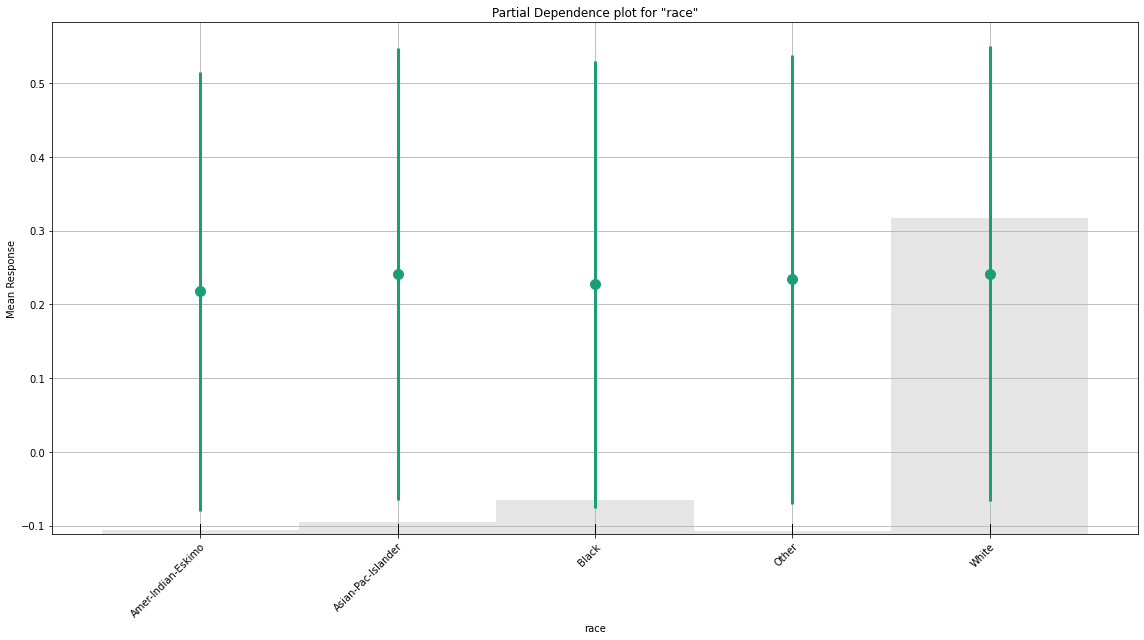

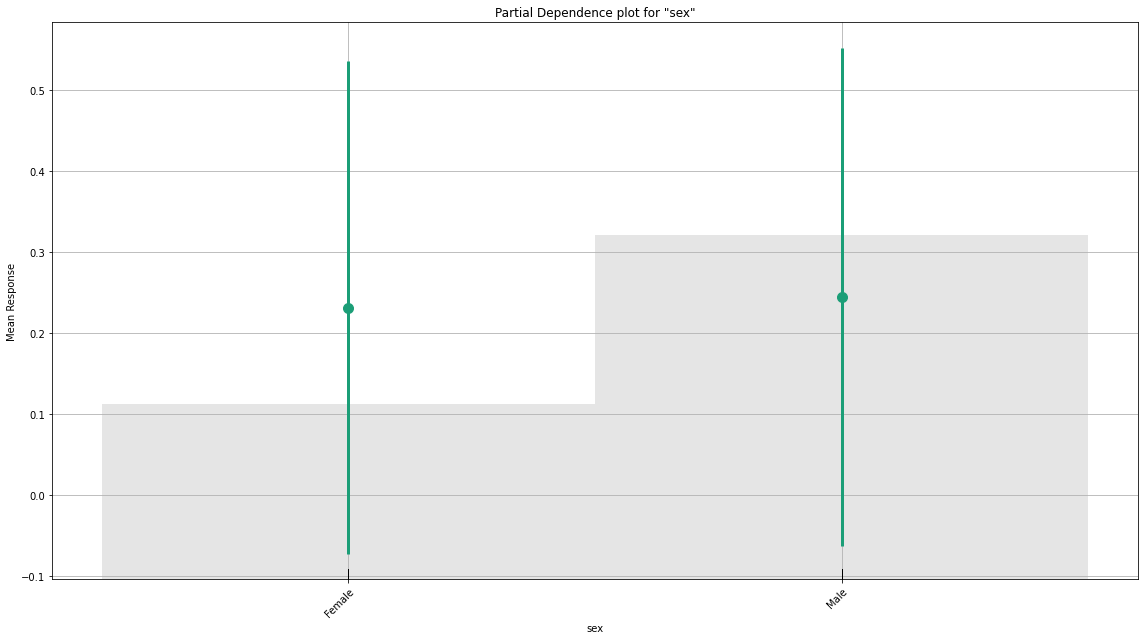

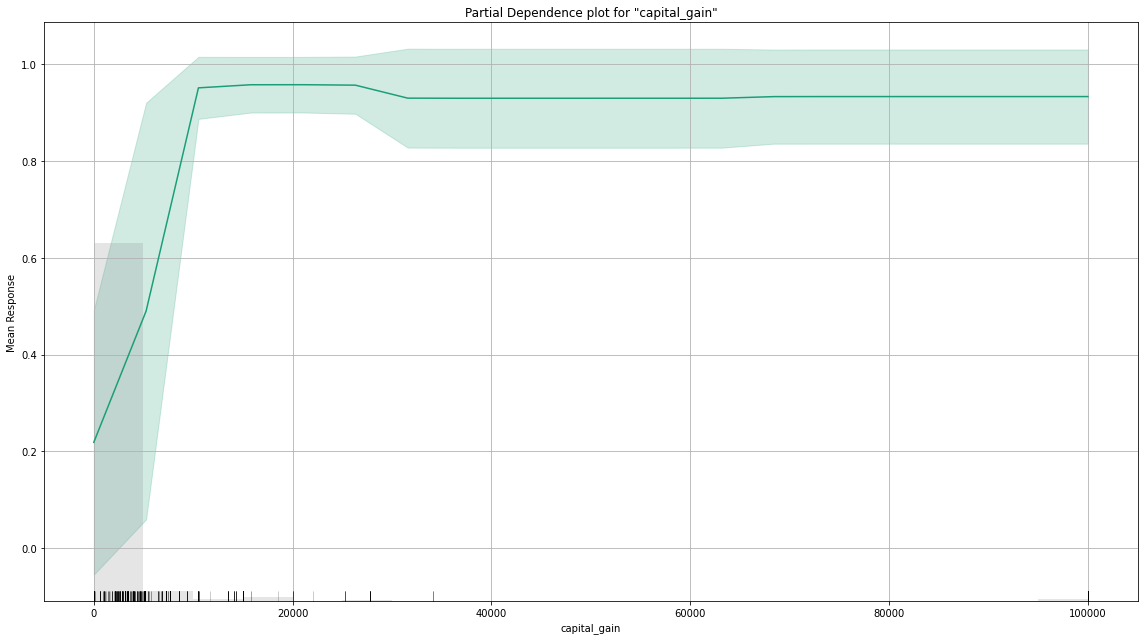

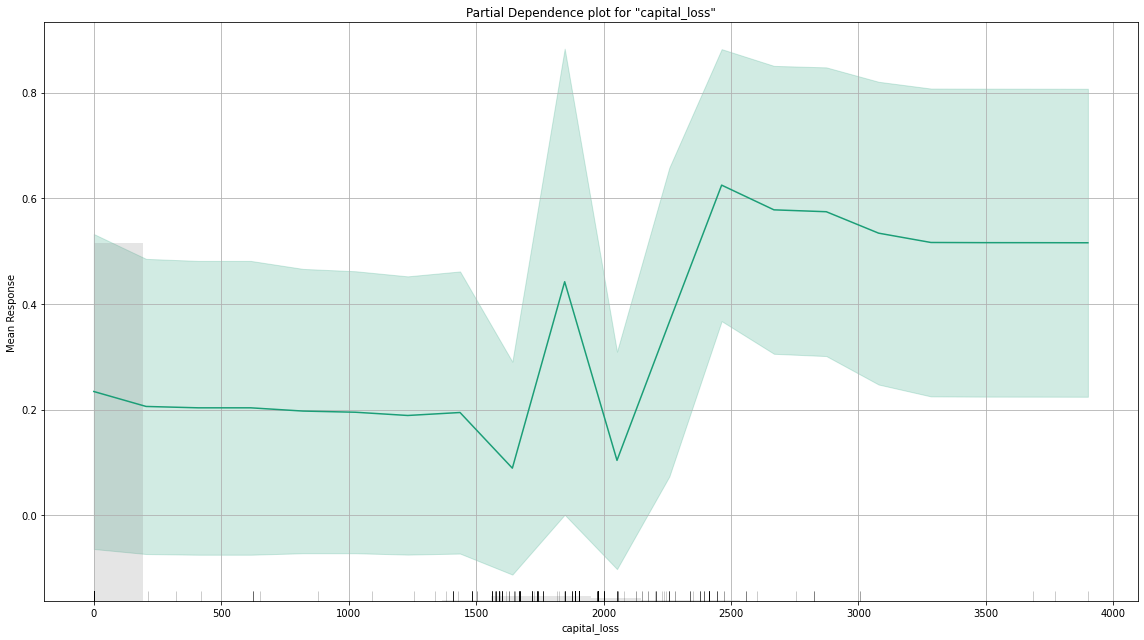

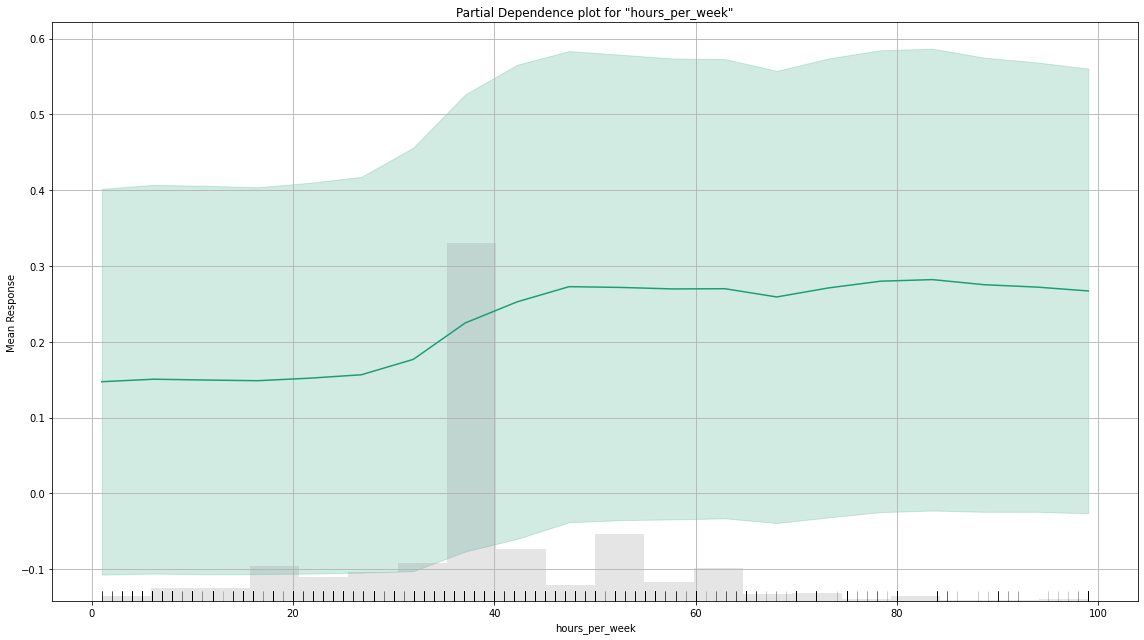

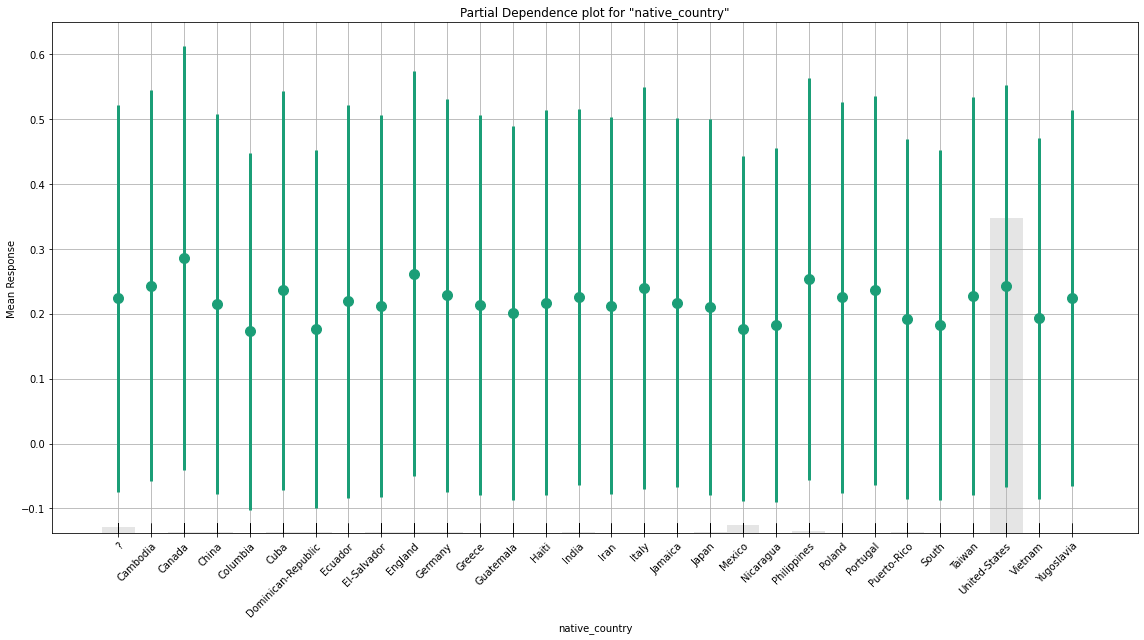

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_2_AutoML_4_20220306_203803


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3811361283040613: 


,,<=50K,>50K,Error,Rate
0,<=50K,6641.0,734.0,0.0995,(734.0/7375.0)
1,>50K,550.0,1788.0,0.2352,(550.0/2338.0)
2,Total,7191.0,2522.0,0.1322,(1284.0/9713.0)


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

In [34]:
model_automl.get_best_model().explain(adult_valid_h2o)

## Explainability

In [14]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [11]:
import matplotlib_inline, matplotlib
model_automl.explain()

TypeError: explain() missing 1 required positional argument: 'frame'

In [15]:
ss.stop()